In [3]:
import pandas as pd
import numpy as np
import os
import nltools as nlt
import nilearn as nil
import nibabel as nib
import warnings
import glob
import random
import pickle

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


This file based on `test_run_prediction_multiple_subs`.

The aim here is that we will:

 - analyze the entire 6.5 seconds of activity
 - take one beta, HRF average across that period
 - spatially filter on vmPFC for a start; then we might look at some other regions
 - use all the subjects gathered so far, but results will be provisional for now and more subjects will be added

### Load brain data

In [2]:
pd.set_option('display.max_rows', 99)

In [4]:
with open('../data/Brain_Data_75subs.pkl', 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

In [9]:
Brain_Data_allsubs

dtype('float32')

In [9]:
with open('../data/Brain_Data_75subs.pkl', 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)
    
brain_data_subs=Brain_Data_allsubs.X.subject.unique()

test_train_set = pd.read_csv("../data/train_test_markers_20210601T183243.csv")

holdout_subs_set = set(test_train_set[test_train_set.SplitGroup=="Holdout"].sub_label)
train_subs_set = set(test_train_set[test_train_set.SplitGroup=="Train"].sub_label)
holdout_data_intersection = holdout_subs_set.intersection(brain_data_subs)
train_data_intersection = train_subs_set.intersection(brain_data_subs)

if len(holdout_data_intersection)>0:
    del Brain_Data_allsubs
    raise Exception("The brain data contains a subject marked for holdout. Do not process!")
else:
    print("checked for intersection and no intersection between the brain data and the subjects was found.")
    if len(train_data_intersection)==0:
        del Brain_Data_allsubs
        raise Exception("the brain data doesn't contain any of the train data. something is wrong.")
    else:
        print("there were " + str(len(train_data_intersection)) + " subjects overlapping between the subjects marked for train data and the training dump file itself.")

    

checked for intersection and no intersection between the brain data and the subjects was found.
there were 60 subjects overlapping between the subjects marked for train data and the training dump file itself.


Good! No intersection

#### get mask

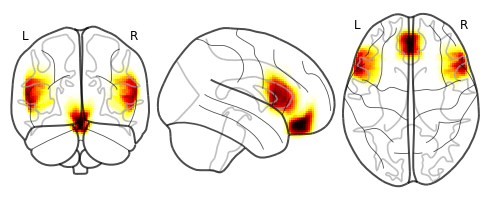

In [10]:
from nilearn.plotting import plot_glass_brain
from nilearn.masking import compute_brain_mask


mask_series = nlt.Brain_Data(
    ["../data/masks/harvardoxford-cortical_prob_Frontal Medial Cortex.nii.gz",
    "../data/masks/harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars opercularis.nii.gz",
    "../data/masks/harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars triangularis.nii.gz"])

mask_aggregate_nifti= mask_series.sum().to_nifti()
plot_glass_brain(mask_aggregate_nifti)


In [11]:
np.histogram(mask_aggregate_nifti.get_fdata())

(array([894787,   2702,   1455,   1195,    753,    703,    518,    308,
           124,     84]),
 array([ 0. ,  9.6, 19.2, 28.8, 38.4, 48. , 57.6, 67.2, 76.8, 86.4, 96. ]))

In [12]:
np.sum(mask_aggregate_nifti.get_fdata()>1)

13251

In [13]:
np.sum(mask_aggregate_nifti.get_fdata()>10)

7491

In [14]:
np.sum(mask_aggregate_nifti.get_fdata()>25)

4138

In [15]:
mask_binarized = nil.image.new_img_like(mask_aggregate_nifti,(mask_aggregate_nifti.get_fdata()>5).astype(float))

### apply mask

## CV

In [17]:
Brain_Data_allsubs.X.response.value_counts()

5.0    1164
6.0    1018
7.0     904
8.0     604
Name: response, dtype: int64

A final word for today: can we predict the WTP choice? Now, remember that this data is likely conflated by keypress, so...there's that to be concerned about.

In [18]:
Brain_Data_allsubs.Y = Brain_Data_allsubs.X.response.copy()

In [19]:
Brain_Data_allsubs.Y.value_counts()

5.0    1164
6.0    1018
7.0     904
8.0     604
Name: response, dtype: int64

In [20]:
Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None

to do this we need to remove the null-response items.

In [21]:
Brain_Data_allsubs.Y.value_counts()

5.0    1164
6.0    1018
7.0     904
8.0     604
Name: response, dtype: int64

In [22]:
Brain_Data_allsubs.Y.isnull().value_counts()

False    3690
True      150
Name: response, dtype: int64

In [23]:
Brain_Data_allsubs_nn = Brain_Data_allsubs[Brain_Data_allsubs.Y.isnull()==False]

In [24]:
print(len(Brain_Data_allsubs_nn))
print(len(Brain_Data_allsubs))

3690
3840


In [25]:
Brain_Data_allsubs_nn.Y=Brain_Data_allsubs_nn.Y.astype(int)

In [26]:
Brain_Data_allsubs_masked_nn = Brain_Data_allsubs_nn.apply_mask(mask_binarized,resample_mask_to_brain=True)

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.44204e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.79888e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.86161e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.5132e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsign

overall Root Mean Squared Error: 0.01
overall Correlation: 1.00
overall CV Root Mean Squared Error: 1.11
overall CV Correlation: 0.47


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


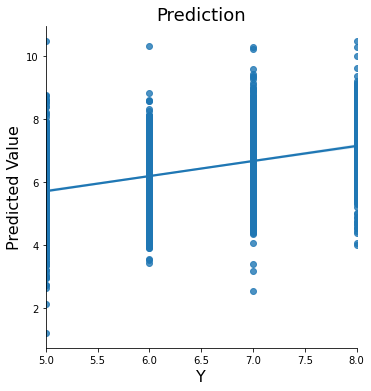

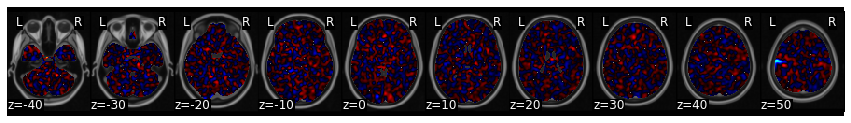

In [27]:
prediction_across_subjects = Brain_Data_allsubs_nn.predict(algorithm='ridge',
                           cv_dict = {'type':'kfolds',
                                      'n_folds':5,
                                      'subject_id':Brain_Data_allsubs_nn.X.subject})

#print(prediction_across_subjects)


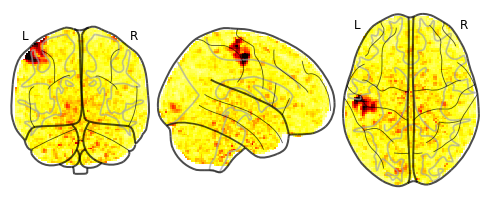

In [32]:
plot_glass_brain(prediction_across_subjects['weight_map'].to_nifti())

In [33]:
weight_map = prediction_across_subjects['weight_map'].to_nifti()

In [39]:
nib.save(weight_map,"../data/initial_weight_map.nii.gz")

Yeah that pretty clearly looks like somatosensory activity, right? So what we're seeing is the finger that selected the item as the main predictor.


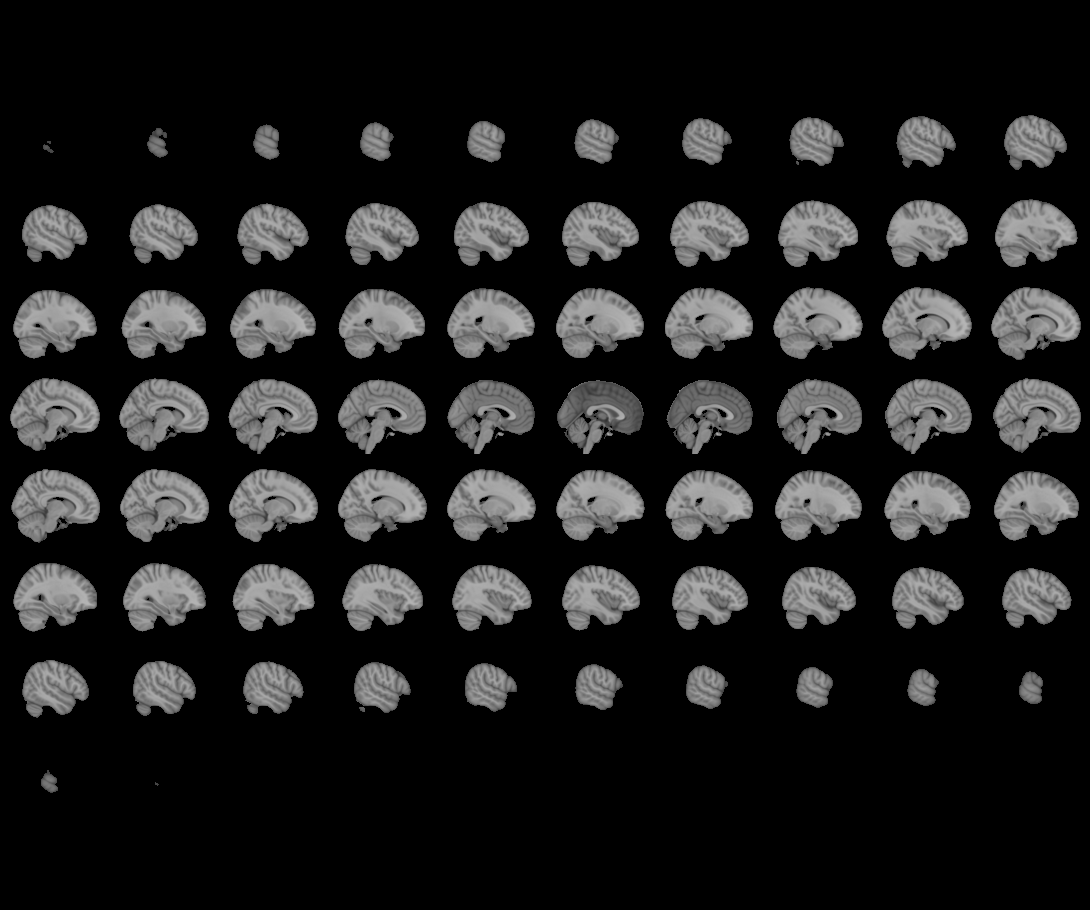
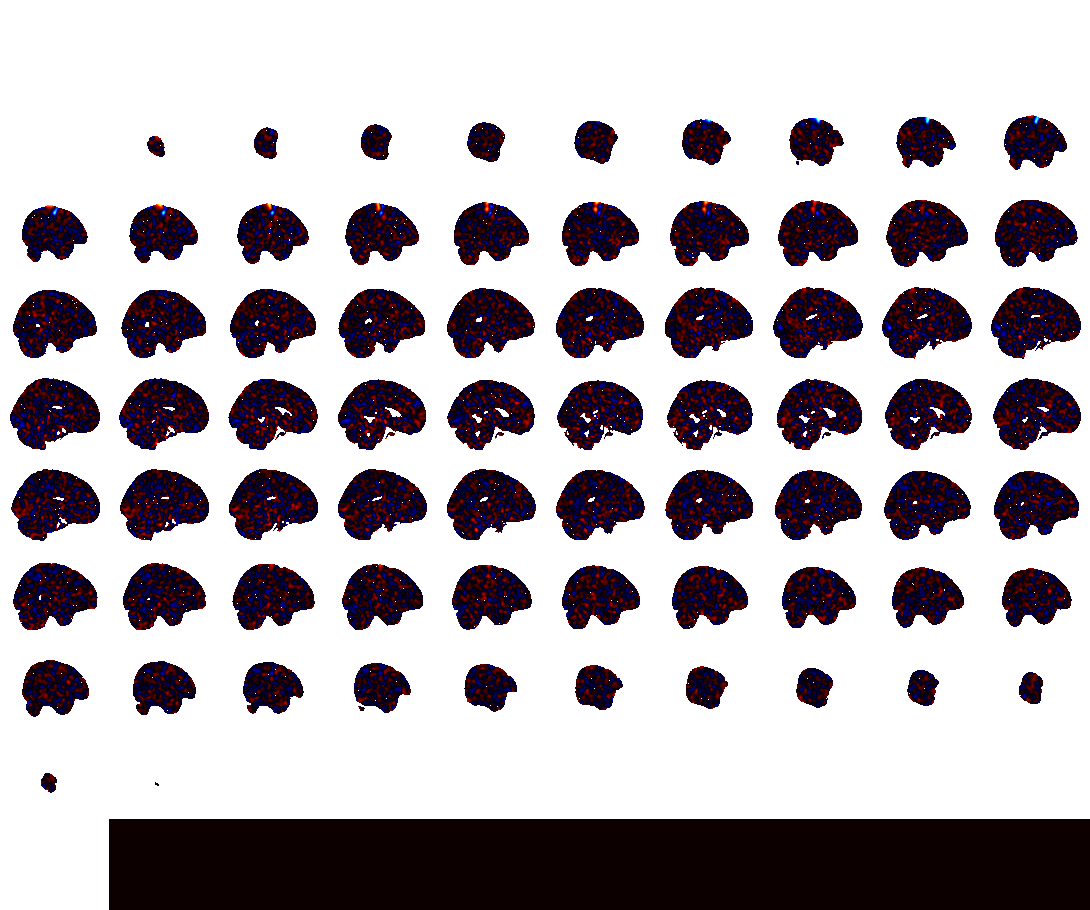

In [34]:
from nilearn import plotting

plotting.view_img(weight_map)

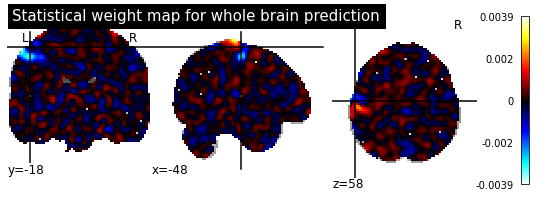

In [35]:
display = plotting.plot_stat_map(
    weight_map,
    title='Statistical weight map for whole brain prediction',
                             cut_coords=[-48, -18, 58])


This particular position has a strong association with 'finger' in neurosynth so that all checks out. We'll need to remove this if we are going to get a meaningful signature!

 - I suspect even if we look at the pre-selection activity, at least after the haemodynamic convolution, we're going to see some finger activity blurred in to the selection.
 - For a whole-brain 'neural signature', we really...need the whole brain! Even if we look at foods that are 'liked', we're going to have a correlation with the WTP selection and thus with the finger-press.


Let's go through our options

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.00512e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.76089e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.66054e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.0404e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsign

overall Root Mean Squared Error: 0.33
overall Correlation: 0.95
overall CV Root Mean Squared Error: 2.54
overall CV Correlation: 0.05


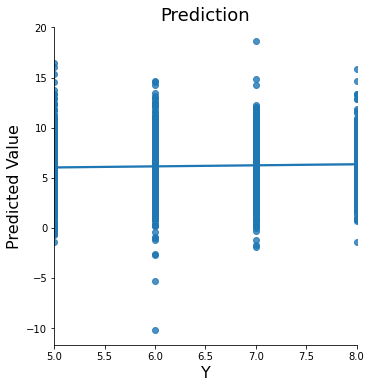

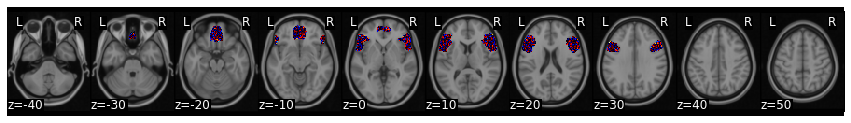

In [36]:
prediction_across_subjects = Brain_Data_allsubs_masked_nn.predict(algorithm='ridge',
                           cv_dict = {'type':'kfolds',
                                      'n_folds':5,
                                      'subject_id':Brain_Data_allsubs_masked_nn.X.subject})

#print(prediction_across_subjects)


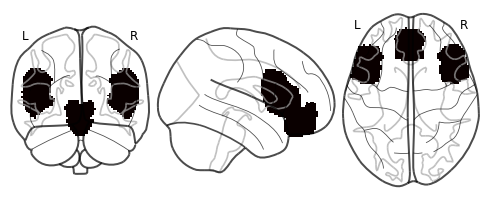

In [16]:
plot_glass_brain(mask_binarized)

## Within-subject....

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.00512e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=False, random_state=None as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.85775e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.11865e-10): result may not 

overall Root Mean Squared Error: 0.33
overall Correlation: 0.95
overall CV Root Mean Squared Error: 2.01
overall CV Correlation: 0.12


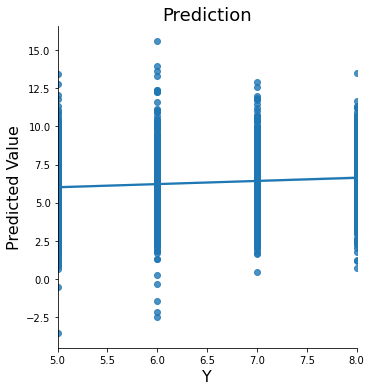

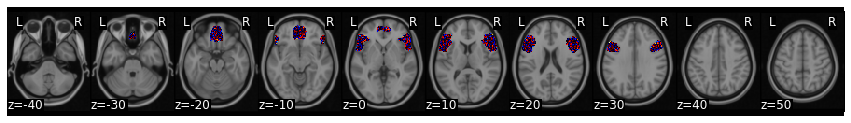

In [38]:
prediction_stratified = Brain_Data_allsubs_masked_nn.predict(algorithm='ridge',
                           cv_dict = {'type':'kfolds',
                                      'n_folds':5,
                                      'stratified':Brain_Data_allsubs_masked_nn.Y.astype(int)})

#print(prediction_stratified)

How should we measure chance performance? One way is to re-run this 1000 times with dummy-assigned y variables and record the output, but there must be an easier way to do that?

### 'Virtual lesion' approach

I examined the above mask in FSLeyes and observed that, the most strongly indicative pieces of activity were in locations related in neurosynth.org most strongly with the visual cortex (particulalry V1) or the somatosensory cortex (particularly that related to the fingers). So to remove these from the analysis we can remove regions that overlap with those.

We can try masking using the following Harvard-Oxford masks:

 - Visual areas (intracalcarine cortex and occipital pole)
 - Somatosensory cortex (precentral gyrus, postcentral gyrus)

#### Attempt 1.

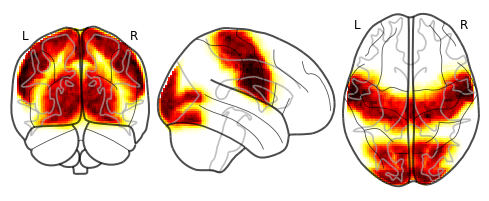

In [55]:
virtual_lesion_mask_series = nlt.Brain_Data(
    ["../data/masks/harvardoxford-cortical_prob_Occipital Pole.nii.gz",
    "../data/masks/harvardoxford-cortical_prob_Intracalcarine Cortex.nii.gz",
    "../data/masks/harvardoxford-cortical_prob_Precentral Gyrus.nii.gz",
    "../data/masks/harvardoxford-cortical_prob_Postcentral Gyrus.nii.gz",
    "../data/masks/harvardoxford-cortical_prob_Occipital Fusiform Gyrus.nii.gz"])


virtual_lesion_aggregate_nifti= virtual_lesion_mask_series.sum().to_nifti()
plot_glass_brain(virtual_lesion_aggregate_nifti)


In [56]:
virtual_lesion_binarized = nil.image.new_img_like(
    virtual_lesion_aggregate_nifti,
    (virtual_lesion_aggregate_nifti.get_fdata()<=0).astype(float))

In [57]:
Brain_Data_allsubs_vl_nn = Brain_Data_allsubs_nn.apply_mask(virtual_lesion_binarized,resample_mask_to_brain=False)

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.89112e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.29325e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.33633e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.04858e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsig

overall Root Mean Squared Error: 0.01
overall Correlation: 1.00
overall CV Root Mean Squared Error: 1.43
overall CV Correlation: 0.22


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


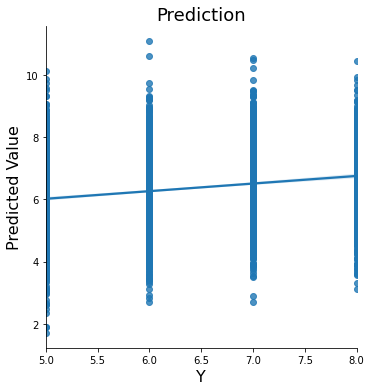

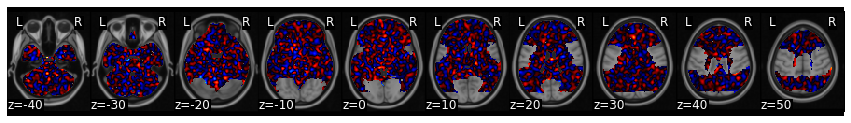

In [58]:
prediction_across_subjects = Brain_Data_allsubs_vl_nn.predict(algorithm='ridge',
                           cv_dict = {'type':'kfolds',
                                      'n_folds':5,
                                      'subject_id':Brain_Data_allsubs_vl_nn.X.subject})

#print(prediction_across_subjects)



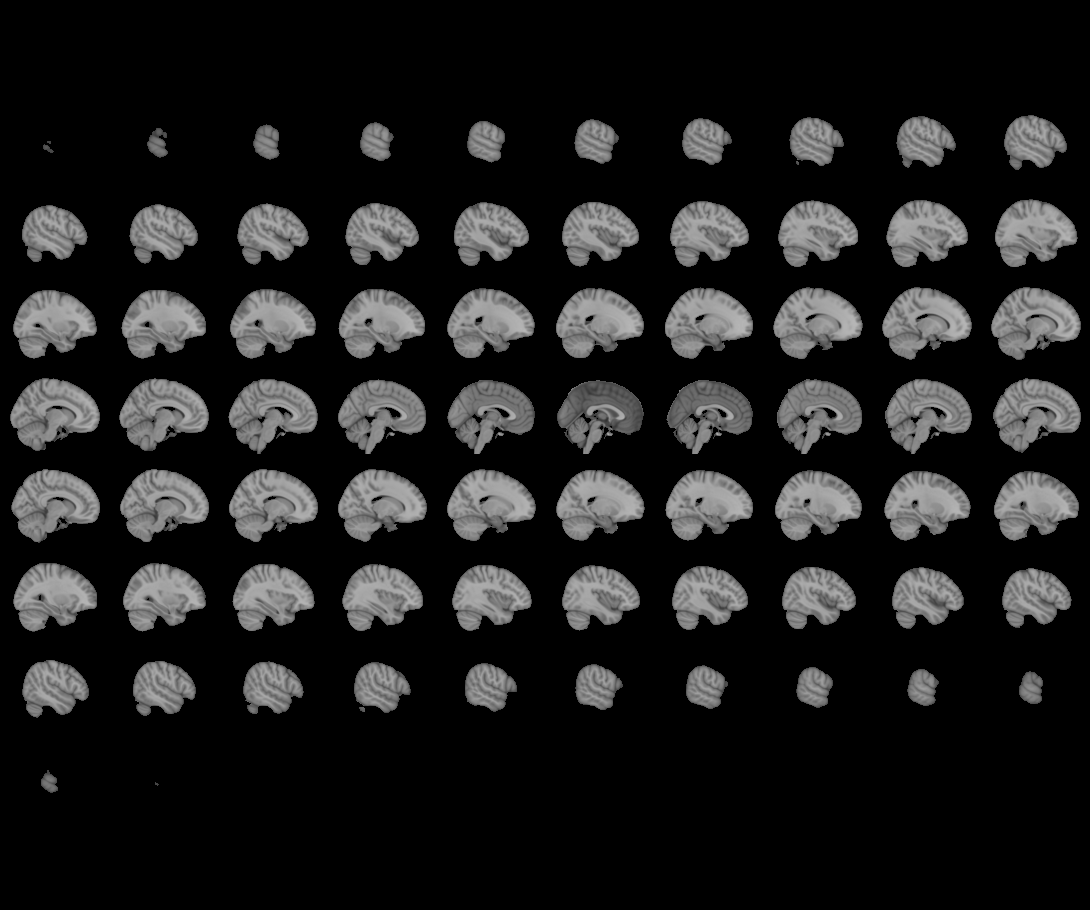
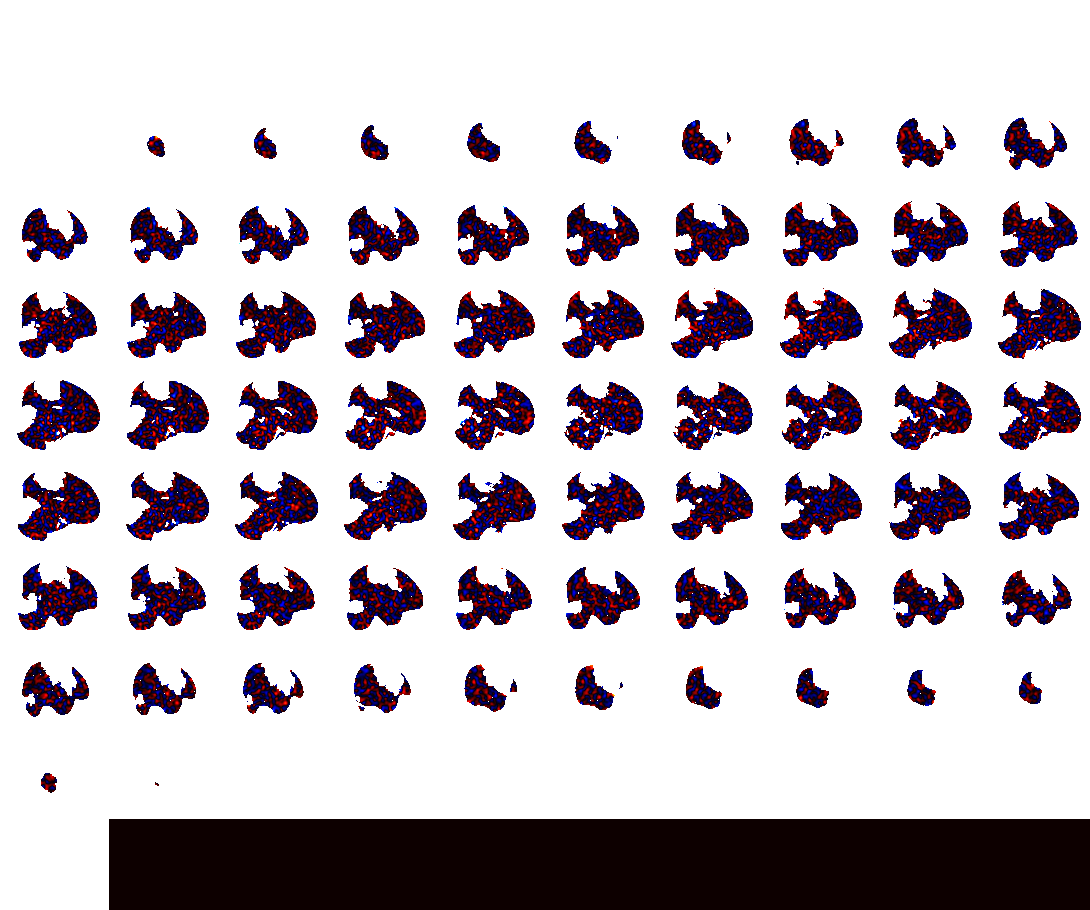

In [59]:
from nilearn import plotting

plotting.view_img(prediction_across_subjects['weight_map'].to_nifti())

#### Attempt 2.

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/plotting/html_document.py:56: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



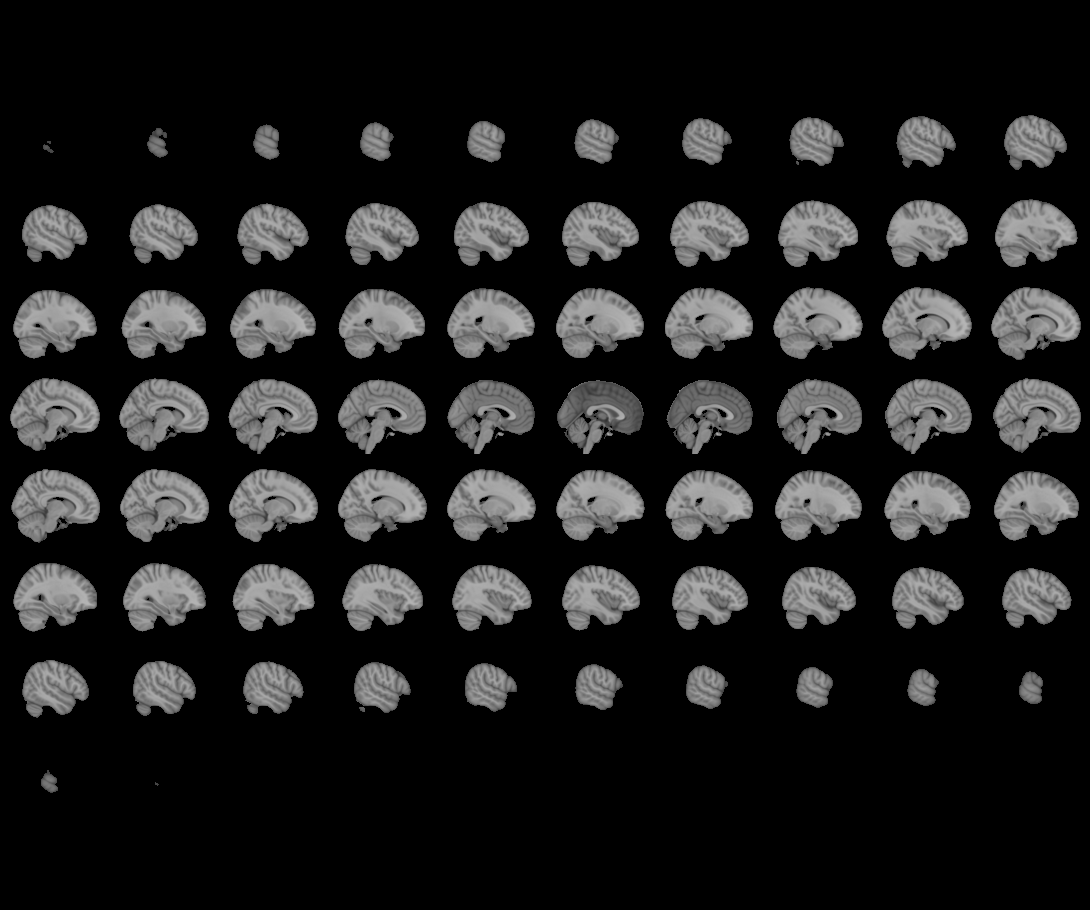
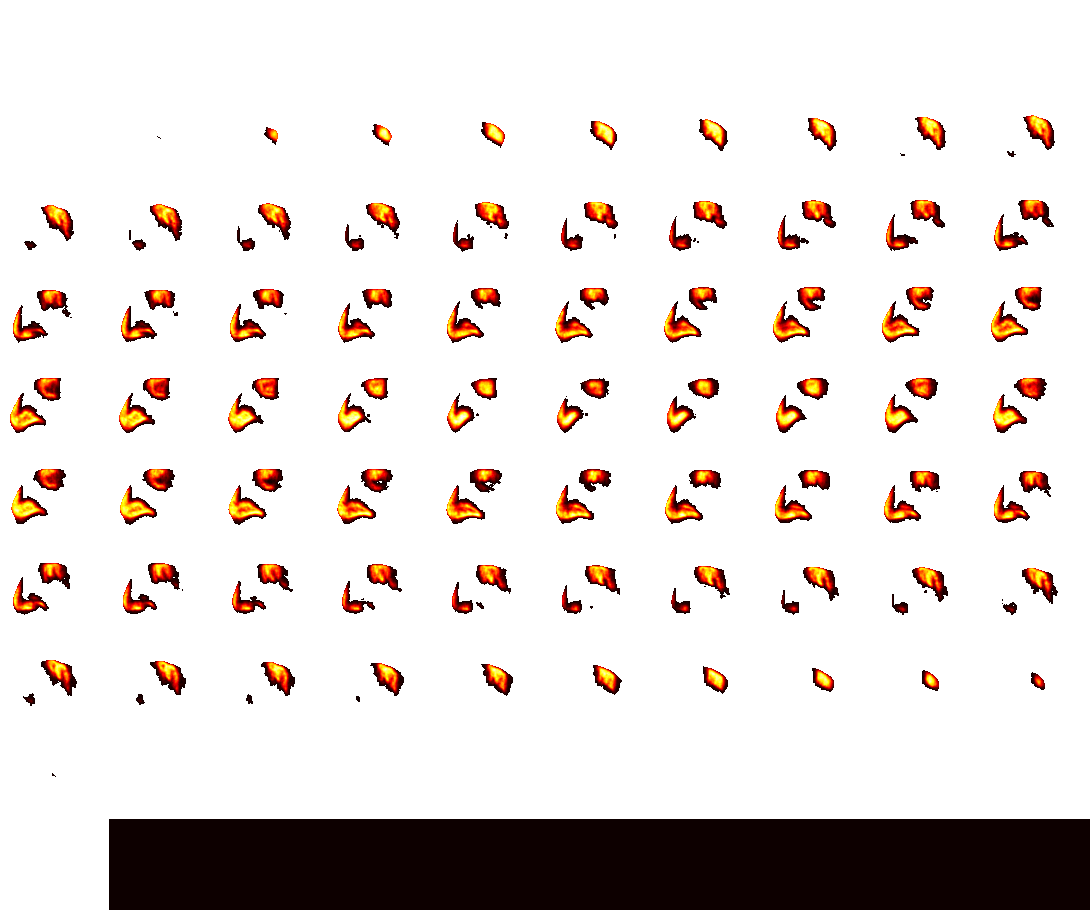

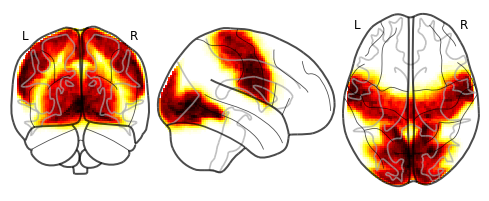

In [85]:
virtual_lesion_mask_series2 = nlt.Brain_Data(
    ["../data/masks/harvardoxford-cortical_prob_Occipital Pole.nii.gz",
    "../data/masks/harvardoxford-cortical_prob_Intracalcarine Cortex.nii.gz",
    "../data/masks/harvardoxford-cortical_prob_Precentral Gyrus.nii.gz",
    "../data/masks/harvardoxford-cortical_prob_Postcentral Gyrus.nii.gz",
    "../data/masks/harvardoxford-cortical_prob_Occipital Fusiform Gyrus.nii.gz",
    "../data/masks/harvardoxford-cortical_prob_Lingual Gyrus.nii.gz"
    ])


virtual_lesion_aggregate_nifti= virtual_lesion_mask_series2.sum().to_nifti()
plot_glass_brain(virtual_lesion_aggregate_nifti)

virtual_lesion_binarized = nil.image.new_img_like(
    virtual_lesion_aggregate_nifti,
    (virtual_lesion_aggregate_nifti.get_fdata()<=0).astype(float))

Brain_Data_allsubs_vl2_nn = Brain_Data_allsubs_nn.apply_mask(virtual_lesion_binarized,resample_mask_to_brain=False)

from nilearn import plotting

plotting.view_img(virtual_lesion_aggregate_nifti)


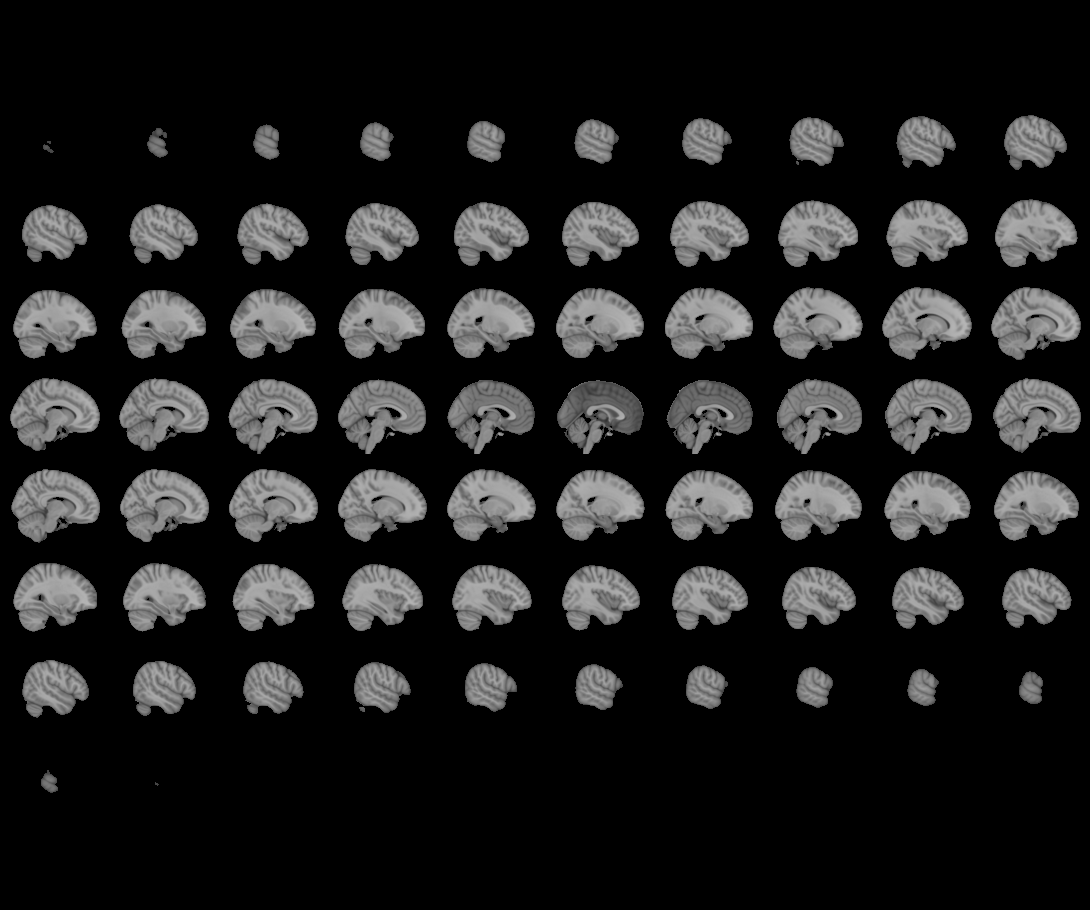
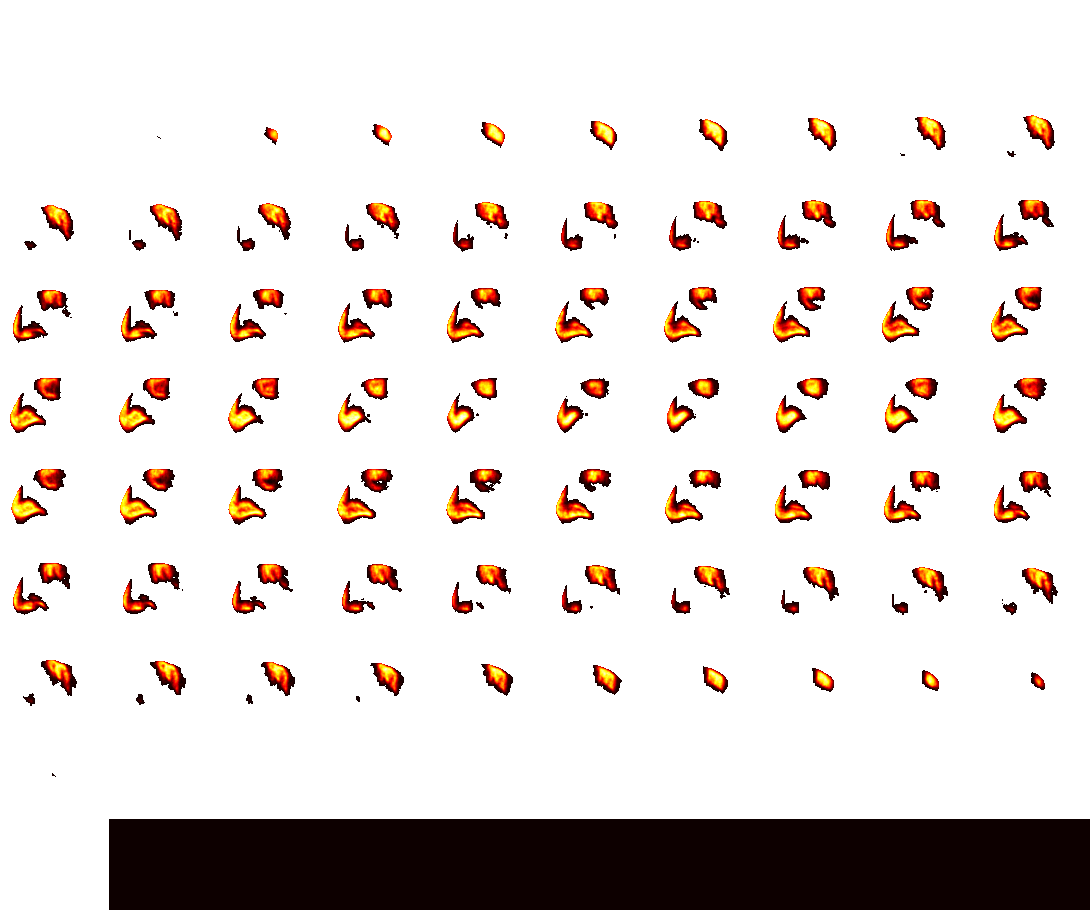

In [71]:
from nilearn import plotting

plotting.view_img(virtual_lesion_aggregate_nifti)

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.12021e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.53259e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.03135e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.83547e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsig

overall Root Mean Squared Error: 0.01
overall Correlation: 1.00
overall CV Root Mean Squared Error: 1.45
overall CV Correlation: 0.21


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


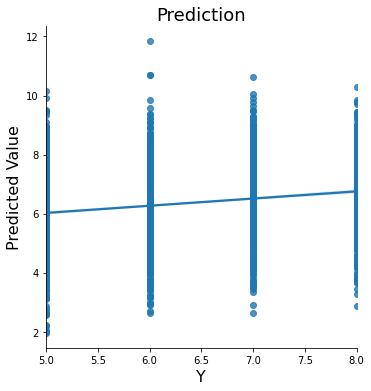

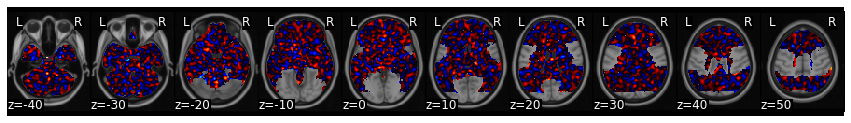

In [86]:
prediction_across_subjects = Brain_Data_allsubs_vl2_nn.predict(algorithm='ridge',
                           cv_dict = {'type':'kfolds',
                                      'n_folds':5,
                                      'subject_id':Brain_Data_allsubs_vl2_nn.X.subject})

#print(prediction_across_subjects)


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/plotting/html_document.py:56: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



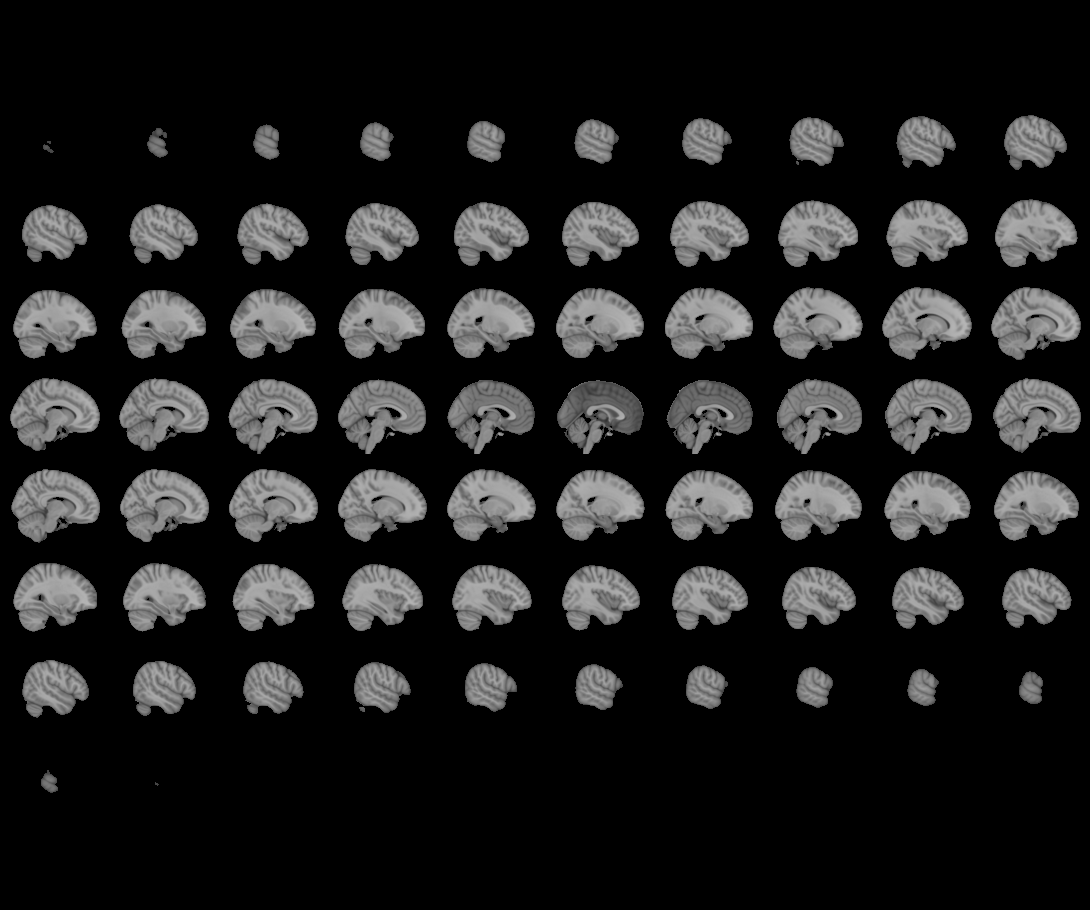
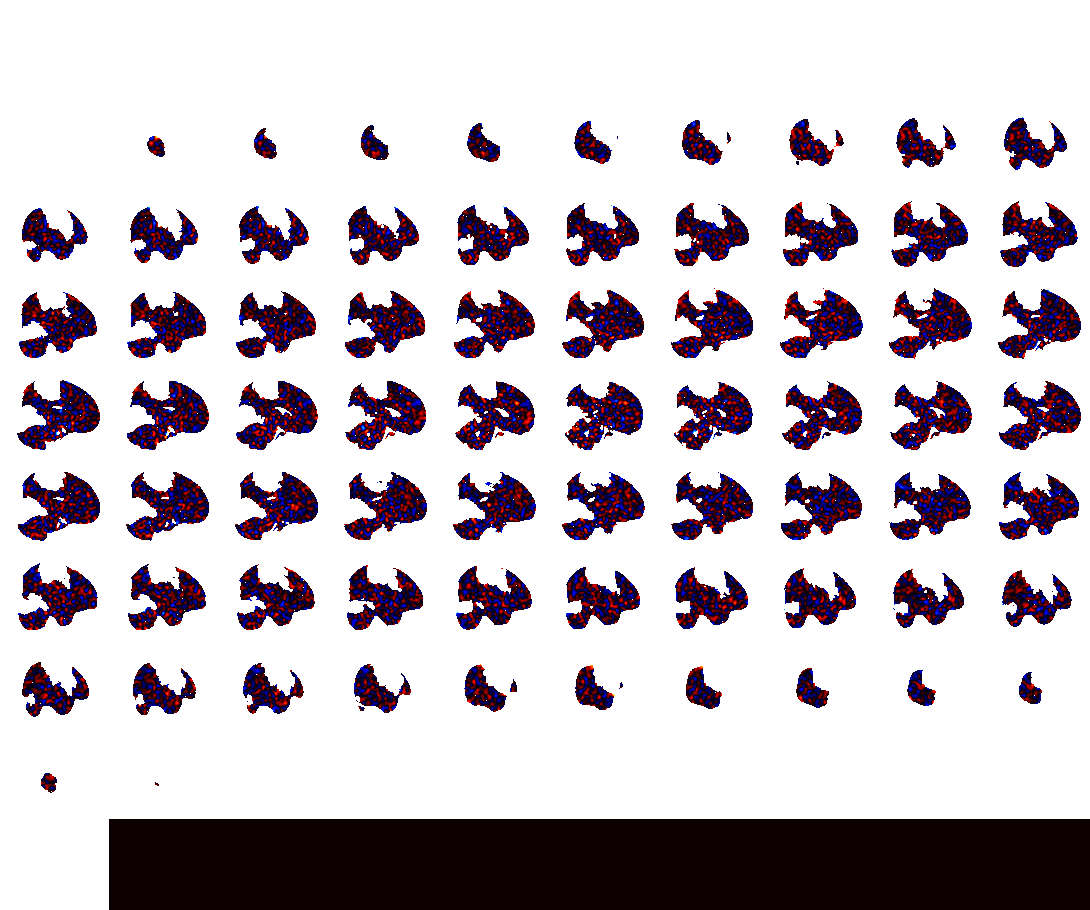

In [87]:
from nilearn import plotting

plotting.view_img(prediction_across_subjects['weight_map'].to_nifti())

#### Attempt 3

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/plotting/html_document.py:56: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



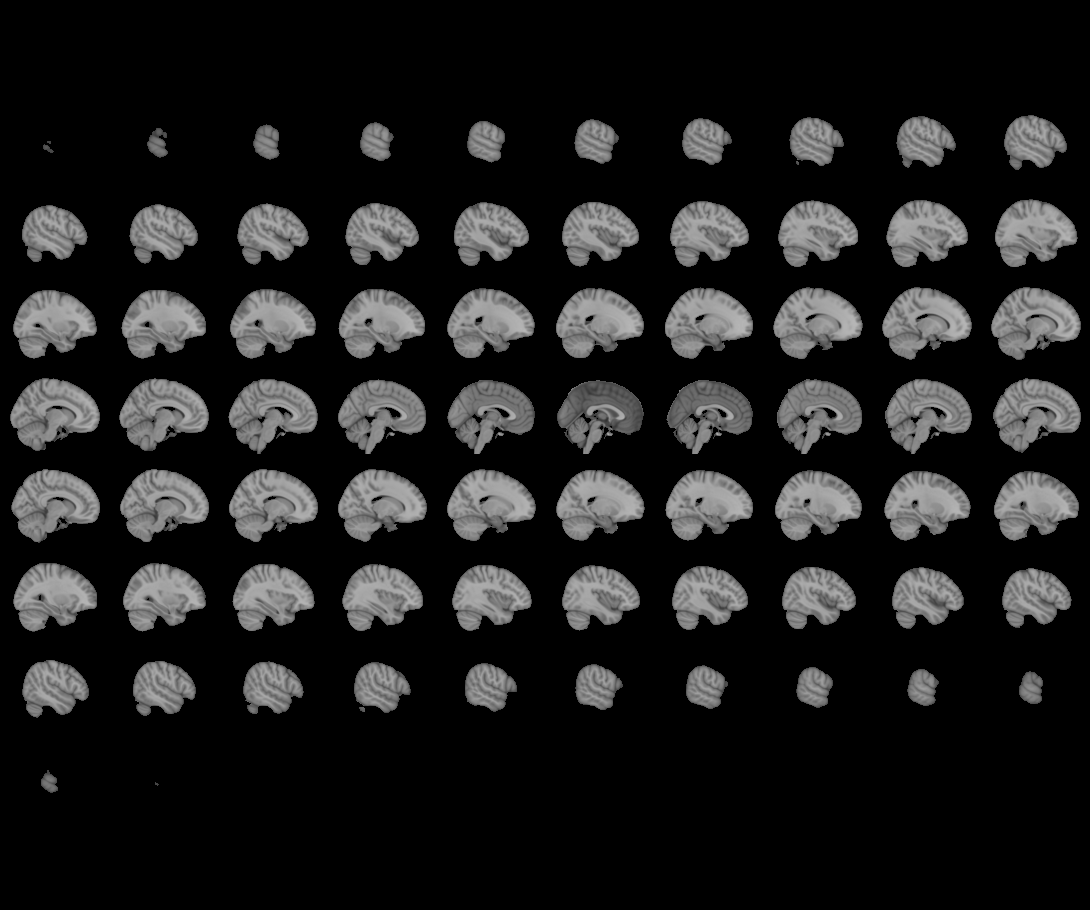
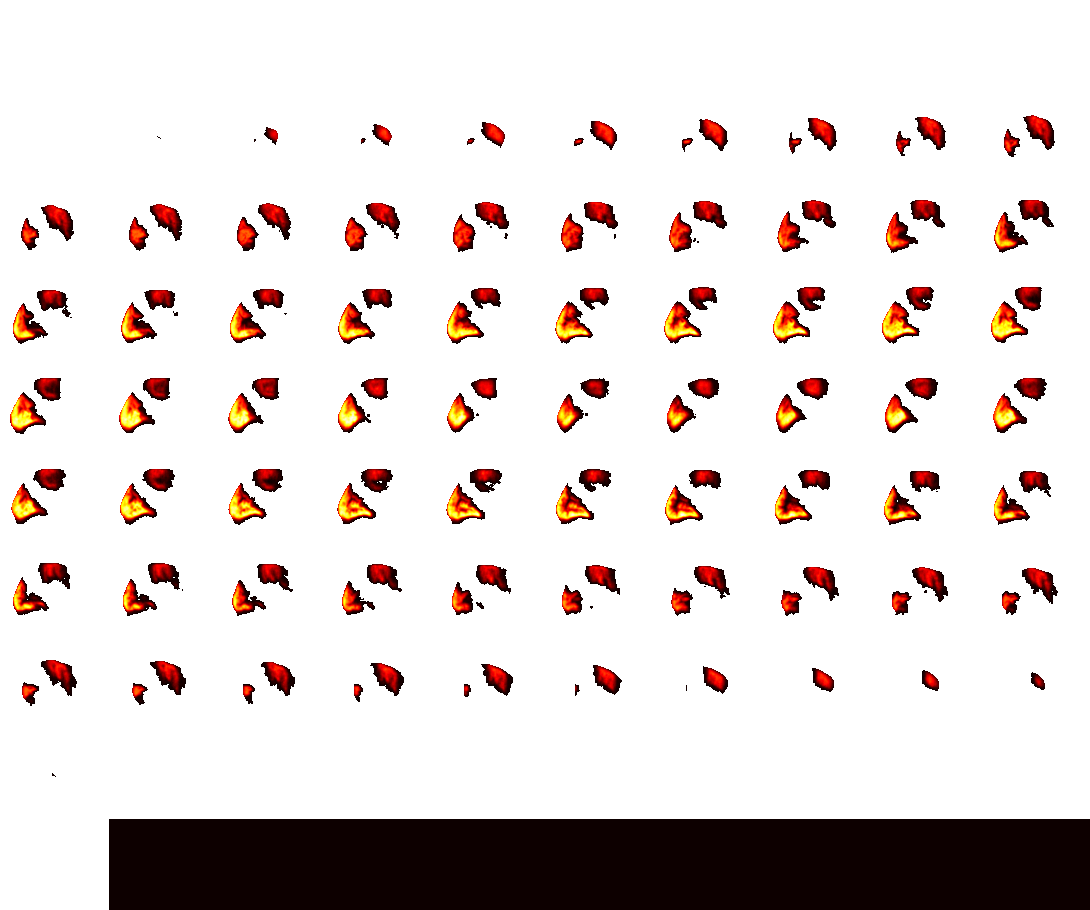

In [88]:
virtual_lesion_mask_series3 = nlt.Brain_Data(
    ["../data/masks/harvardoxford-cortical_prob_Occipital Pole.nii.gz",
    "../data/masks/harvardoxford-cortical_prob_Intracalcarine Cortex.nii.gz",
    "../data/masks/harvardoxford-cortical_prob_Precentral Gyrus.nii.gz",
    "../data/masks/harvardoxford-cortical_prob_Postcentral Gyrus.nii.gz",
    "../data/masks/harvardoxford-cortical_prob_Occipital Fusiform Gyrus.nii.gz",
    "../data/masks/harvardoxford-cortical_prob_Lingual Gyrus.nii.gz",
     "../data/masks/mni_prob_Occipital Lobe.nii.gz"
    ])


virtual_lesion_aggregate_nifti3= virtual_lesion_mask_series3.sum().to_nifti()

virtual_lesion_binarized = nil.image.new_img_like(
    virtual_lesion_aggregate_nifti,
    (virtual_lesion_aggregate_nifti.get_fdata()<=0).astype(float))


Brain_Data_allsubs_vl3_nn = Brain_Data_allsubs_nn.apply_mask(virtual_lesion_binarized,resample_mask_to_brain=False)

from nilearn import plotting

plotting.view_img(virtual_lesion_aggregate_nifti3)

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.12021e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.53259e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.03135e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.83547e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsig

overall Root Mean Squared Error: 0.01
overall Correlation: 1.00
overall CV Root Mean Squared Error: 1.45
overall CV Correlation: 0.21


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


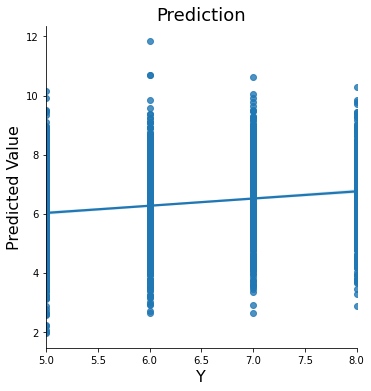

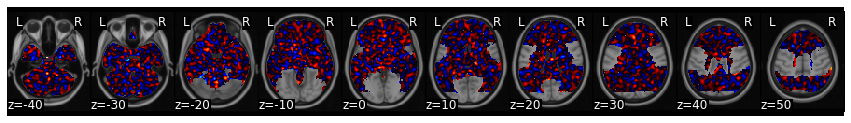

In [91]:
prediction_across_subjects = Brain_Data_allsubs_vl3_nn.predict(algorithm='ridge',
                           cv_dict = {'type':'kfolds',
                                      'n_folds':5,
                                      'subject_id':Brain_Data_allsubs_vl3_nn.X.subject})

#print(prediction_across_subjects)


#### Attempt 4

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/plotting/html_document.py:56: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



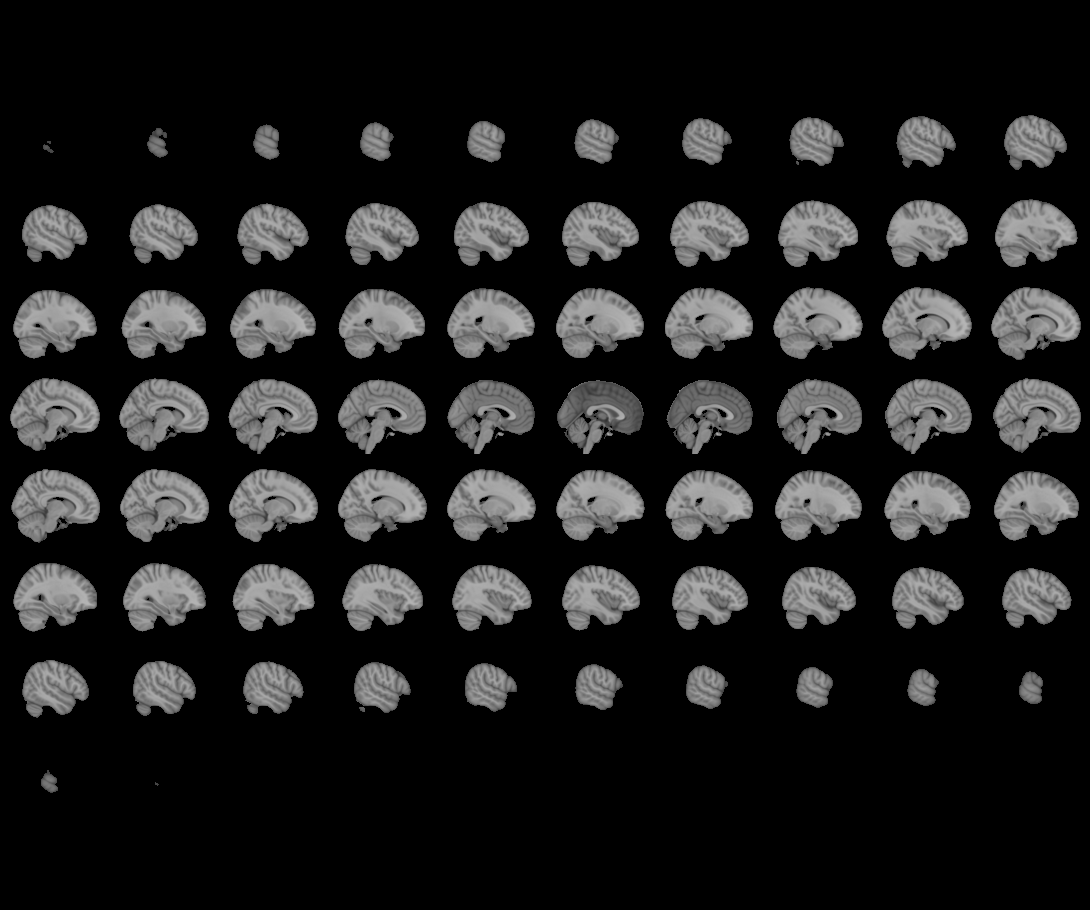
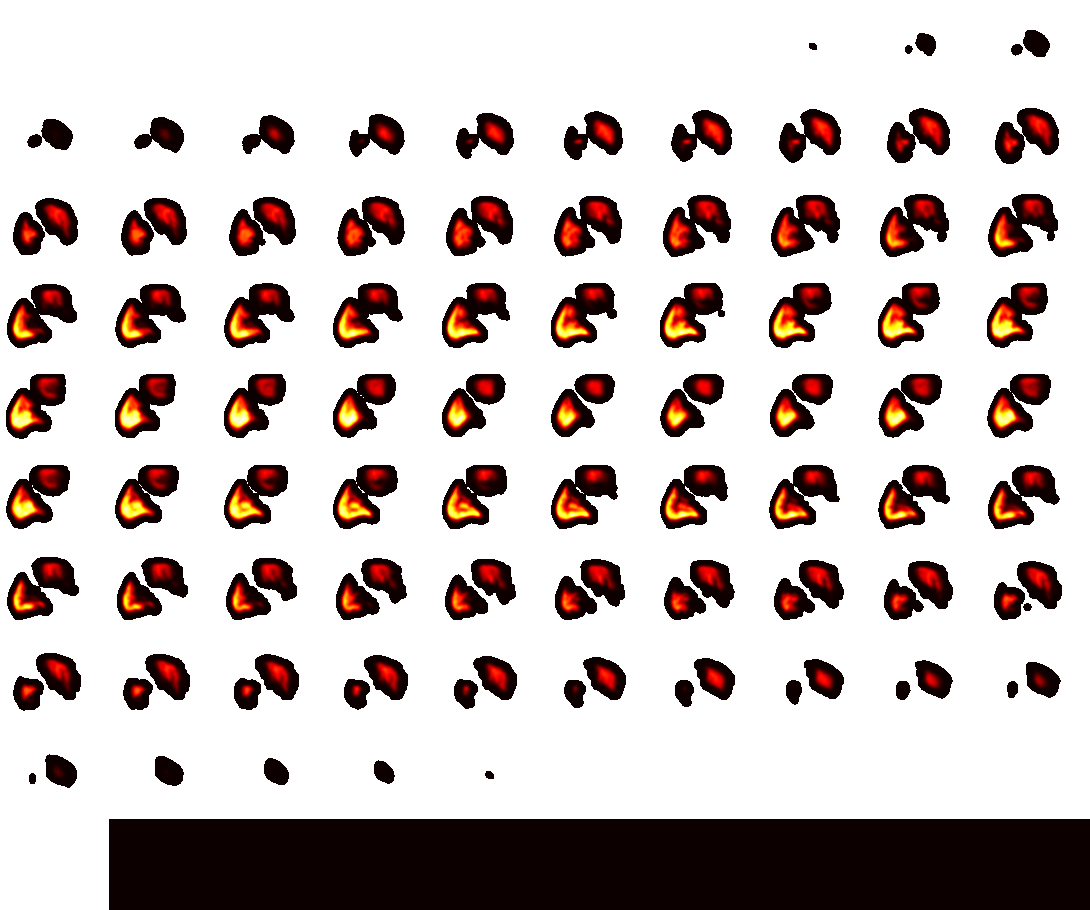

In [92]:
virtual_lesion_aggregate_nifti4 = nil.image.smooth_img(virtual_lesion_aggregate_nifti3,5)

virtual_lesion_binarized = nil.image.new_img_like(
    virtual_lesion_aggregate_nifti4,
    (virtual_lesion_aggregate_nifti4.get_fdata()<=0).astype(float))


Brain_Data_allsubs_vl4_nn = Brain_Data_allsubs_nn.apply_mask(virtual_lesion_binarized,resample_mask_to_brain=False)

from nilearn import plotting

plotting.view_img(virtual_lesion_aggregate_nifti4)


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.70854e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.06392e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.05029e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.12161e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsig

overall Root Mean Squared Error: 0.01
overall Correlation: 1.00
overall CV Root Mean Squared Error: 1.67
overall CV Correlation: 0.15


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


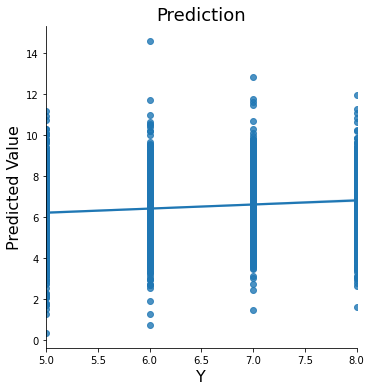

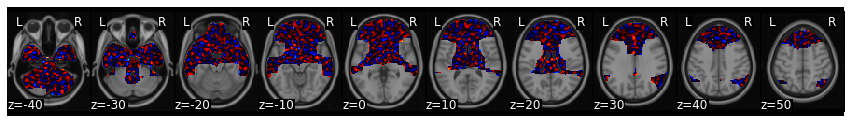

In [93]:
prediction_across_subjects = Brain_Data_allsubs_vl4_nn.predict(algorithm='ridge',
                           cv_dict = {'type':'kfolds',
                                      'n_folds':5,
                                      'subject_id':Brain_Data_allsubs_vl4_nn.X.subject})

#print(prediction_across_subjects)


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/plotting/html_document.py:56: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



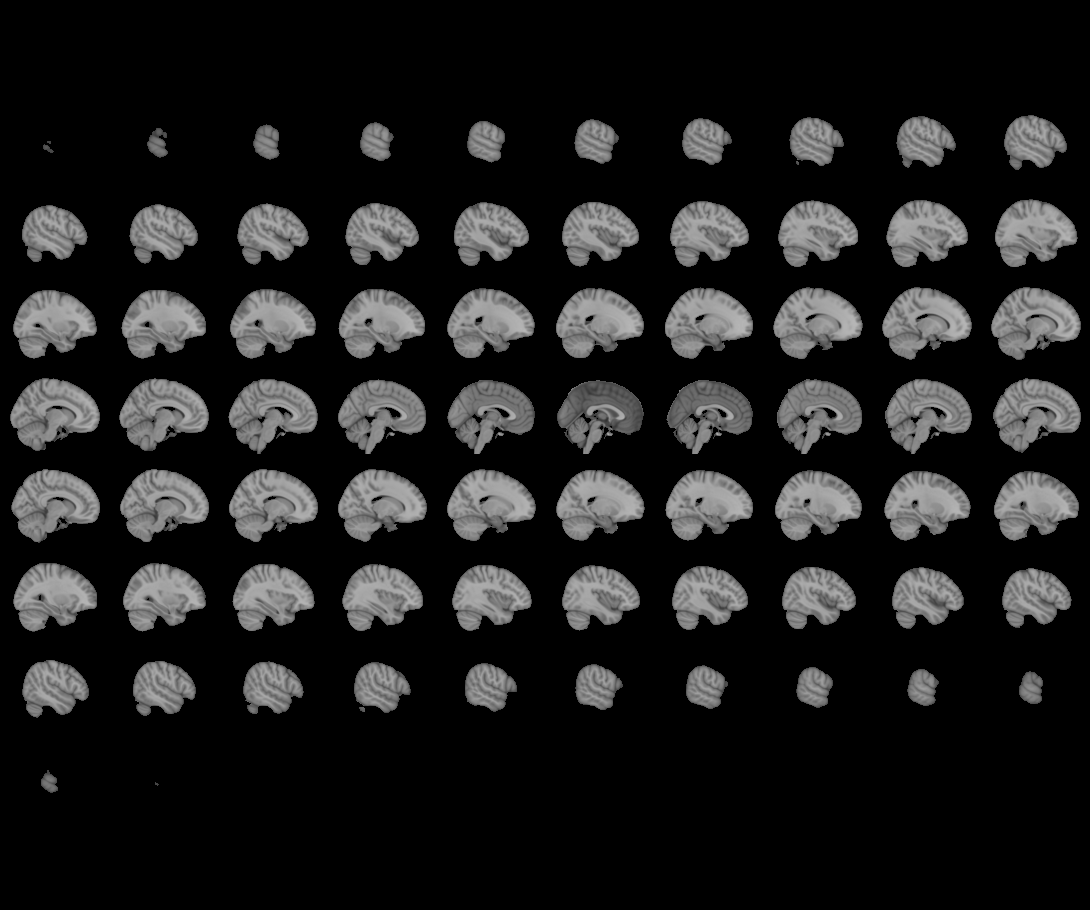
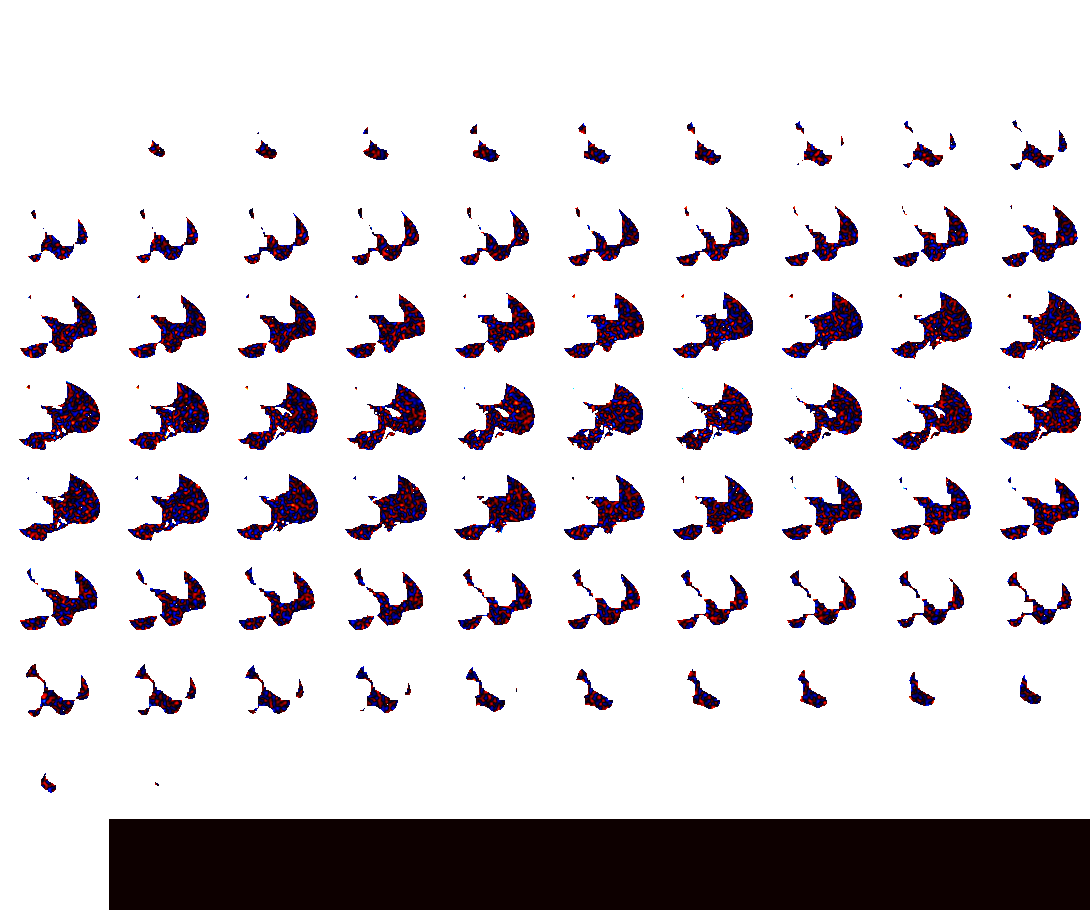

In [94]:
plotting.view_img(prediction_across_subjects['weight_map'].to_nifti())

Areas adjacent to the areas _still_ seem to be some of the most predictive. This is a clear warning sign: these areas are maybe still responding to activity related to vision and somatosensory processing.

I think that puts the nail in the coffin of a neural signature based on these images. We might be ablto use these imagse for something more local but it can't relaly be called a whole-brain neural signature in any way.

We might still be able to do a neural signature of a more-restricted extraction, excluding time points after the finger press itself and excluding the HRF.